R_ij : 4
d2 : 3.563594872561357 delta_const : 1323.2808911132813
y:2.9494420515998607


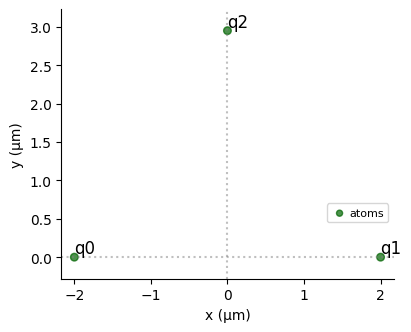

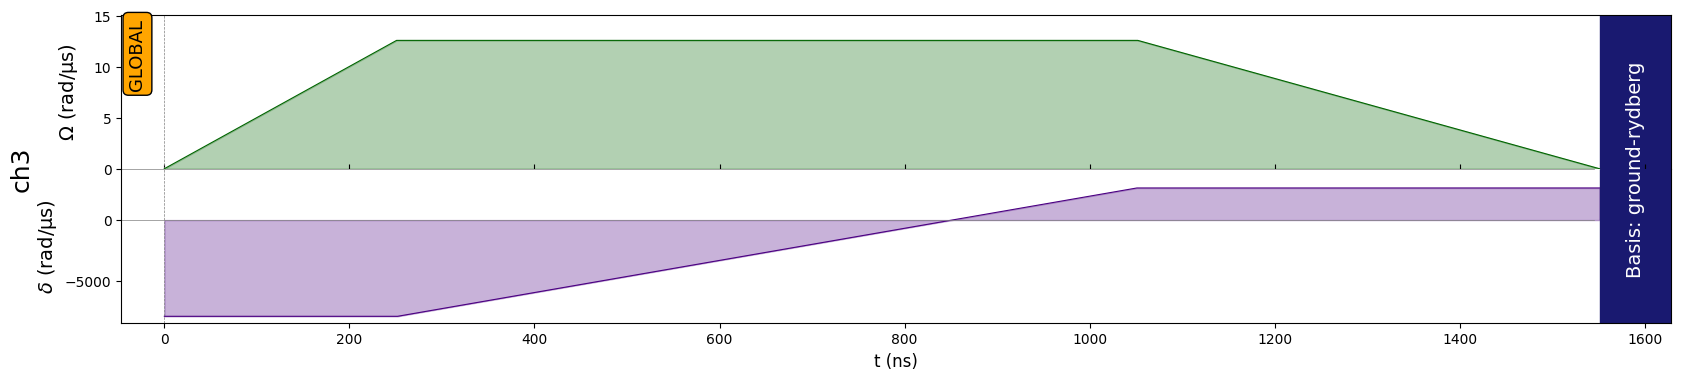

Counter({'000': 952, '001': 42, '100': 2, '010': 2, '101': 1, '110': 1})


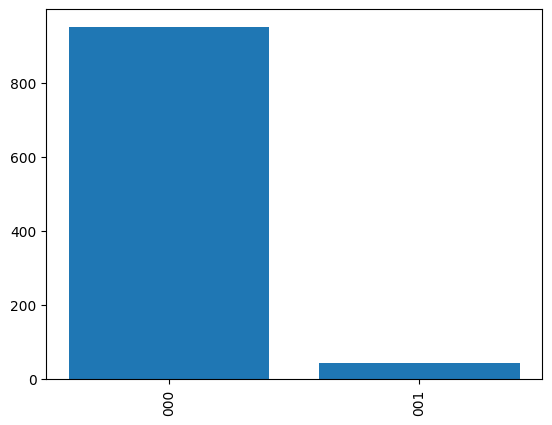

In [ ]:
from pulser import Register, Sequence, Pulse
from pulser.devices import MockDevice, AnalogDevice
from pulser.waveforms import RampWaveform
import pulser
import matplotlib.pyplot as plt
import math

def get_registers(initial_d,distance2): 
    y = math.sqrt(abs((initial_d/2)**2 - distance2**2))
    print(f'y:{y}')
    return Register({
    "q0": (-initial_d/2, 0),
    "q1": (initial_d/2, 0),
    "q2": (0, y),
    })

def set_pulse_sequence(R_ij, C_6, device):
    delta_const = C_6 / (R_ij ** 6)
    dist_2=(0.5*(R_ij**6))**(1/6) # solve for distance2 in this equation : C_6 / (distance1 ** 6) = 0.5 * (C_6/ (distance2 ** 6))
    print(f'd2 : {dist_2} delta_const : {delta_const}')

    reg = get_registers(R_ij,dist_2)
    reg.draw()

    seq = Sequence(reg, device)
    seq.declare_channel("ch3", "rydberg_global")

    delta_0 = -6 * delta_const
    delta_f = 2 * delta_const

    
    amp1 = RampWaveform(252, 0, 12.566370614359172)
    pulse1 = Pulse.ConstantDetuning(amp1, delta_0, 0)

    det2 = RampWaveform(800, delta_0, delta_f)
    pulse2 = Pulse.ConstantAmplitude(12.566370614359172, det2, 0)

    amp3 = RampWaveform(500, 12.566370614359172, 0)
    pulse3 = Pulse.ConstantDetuning(amp3, delta_f, 0)

    seq.add(pulse1, "ch3")
    seq.add(pulse2, "ch3")
    seq.add(pulse3, "ch3")
    seq.measure("ground-rydberg")

    return seq

def run_experiment(backend):
    result = backend.run()
    counts = result.sample_final_state(1000)
    return counts


device = MockDevice
C_6 = device.interaction_coeff
R_ij = 4 # distance in micrometers

print(f"R_ij : {R_ij}")

seq = set_pulse_sequence(R_ij,C_6,device)
seq.draw()
counts = run_experiment(pulser.backends.QutipBackend(seq))

# Let's plot the histogram associated to the measurements
# Let's select only the states that are measured more than 10 times
print(counts)
most_freq = {k: v for k, v in counts.items() if v > 10}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.show()

#(0.5*(d1**6))**(1/6)=d2**(1/6)

In [49]:
d1=5
d2=(0.5*(d1**6))**(1/6)
d2

4.454493590701696

In [69]:
print(seq.available_channels)

{'rydberg_global': Rydberg(addressing='Global', max_abs_detuning=None, max_amp=None, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=None, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None), 'rydberg_local': Rydberg(addressing='Local', max_abs_detuning=None, max_amp=None, min_retarget_interval=0, fixed_retarget_t=0, max_targets=None, clock_period=1, min_duration=1, max_duration=None, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None), 'raman_global': Raman(addressing='Global', max_abs_detuning=None, max_amp=None, min_retarget_interval=None, fixed_retarget_t=None, max_targets=None, clock_period=1, min_duration=1, max_duration=None, min_avg_amp=0, mod_bandwidth=None, custom_phase_jump_time=None, eom_config=None, propagation_dir=None), 'raman_local': Raman(addressing='Local', max_abs_detuning=None, max_amp=None, min_retar

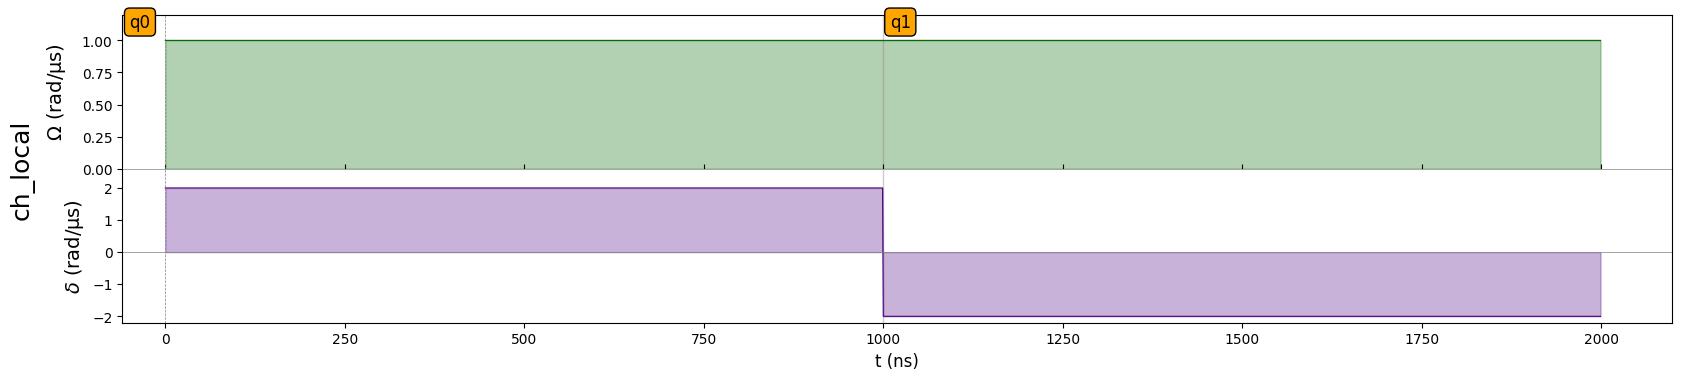

In [ ]:
from pulser import Register, Sequence, Pulse
from pulser.devices import MockDevice
from pulser.waveforms import ConstantWaveform

# Define a 2-qubit register
reg = Register.from_coordinates([(0, 0), (5, 0)], prefix="q")
seq = Sequence(reg, MockDevice)

# Declare a local channel
seq.declare_channel("ch_local", "rydberg_local", initial_target="q0")

# Define a detuned pulse
amp = ConstantWaveform(1000, 1.0)
det = ConstantWaveform(1000, 2.0)  # 2 MHz detuning
pulse = Pulse(amp, det, 0)

# Apply pulse to q0
seq.add(pulse, "ch_local")

# Switch to q1 and apply different detuning
seq.target("q1", "ch_local")
det2 = ConstantWaveform(1000, -2.0)
pulse2 = Pulse(amp, det2, 0)
seq.add(pulse2, "ch_local")
seq.draw()


y:4.424163077399791


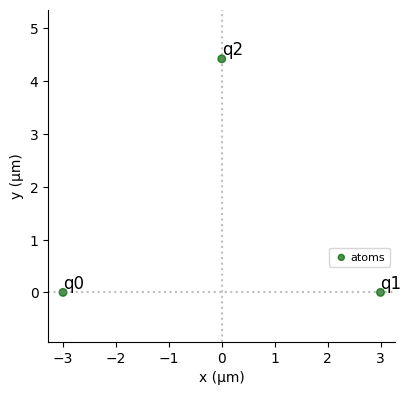

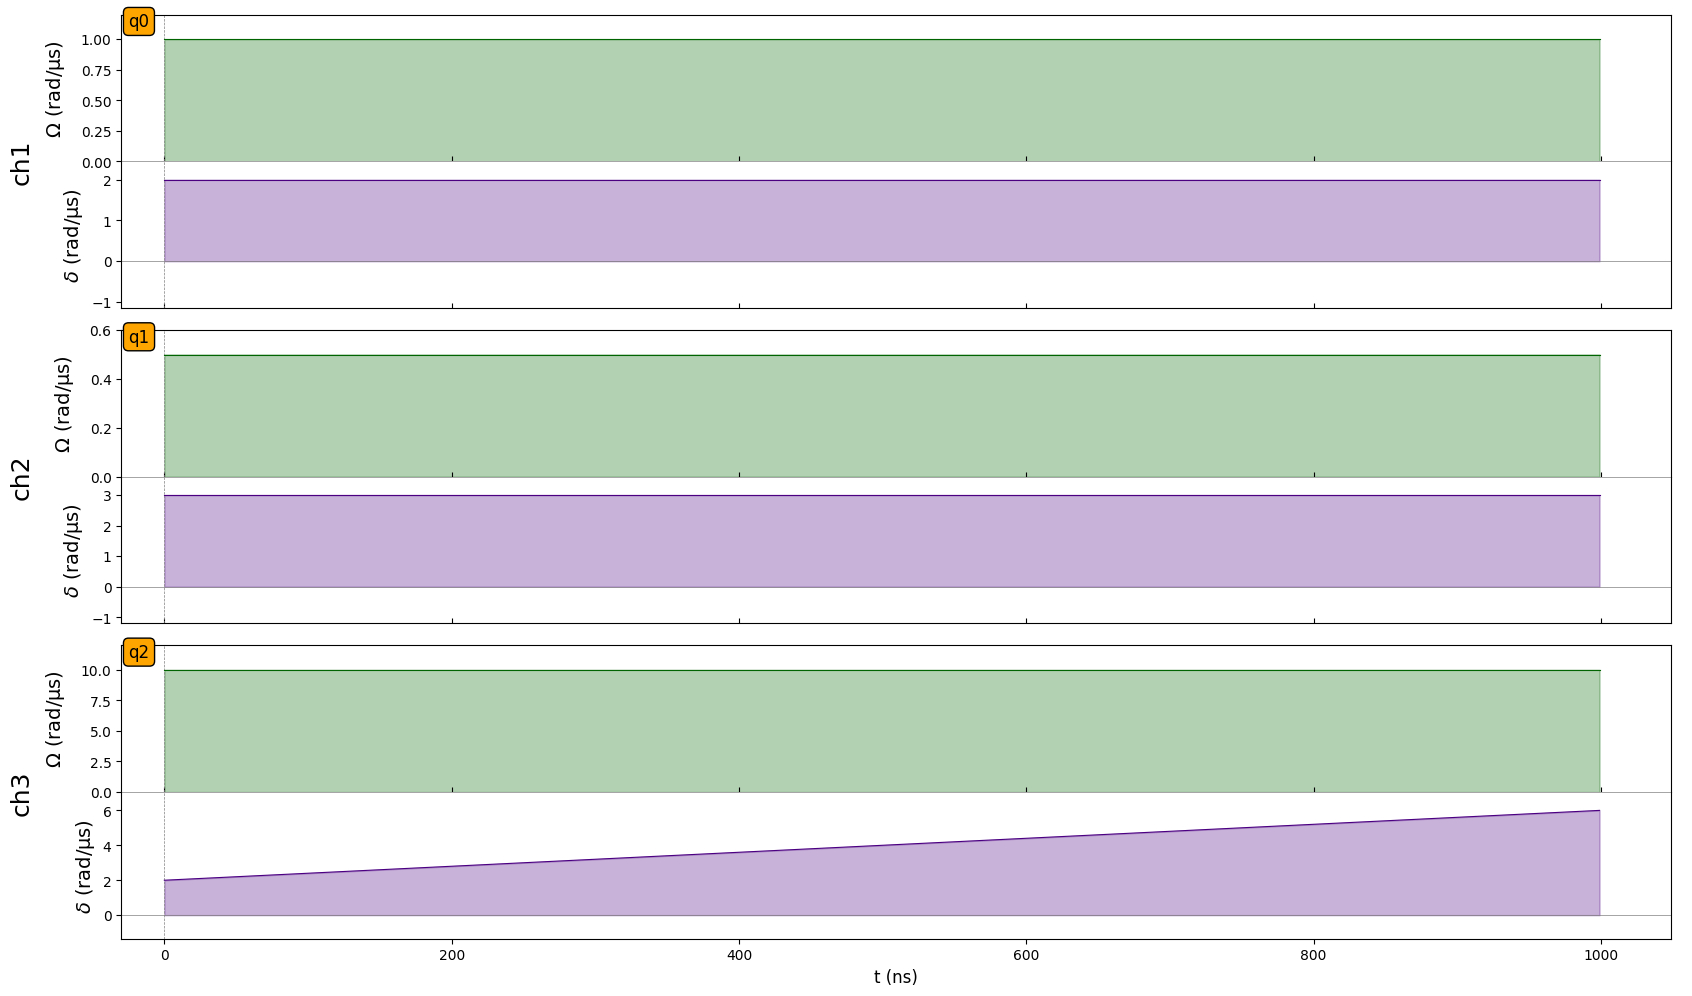

Counter({'001': 505, '000': 488, '100': 4, '010': 3})

In [100]:
import numpy as np
import pulser
from pulser import Register, Sequence, Pulse
from matplotlib import pyplot as plt
from pulser.waveforms import ConstantWaveform, RampWaveform
import math
device = pulser.MockDevice # all channels available at the same time
#device = pulser.DigitalAnalogDevice # only 1 rydberg_local channel available at a time
#device = pulser.AnalogDevice # only 1 rydberg_local channel available at a time
def get_registers(distance1,distance2): 
    y = math.sqrt(abs((distance1/2)**2 - distance2**2))
    print(f'y:{y}')
    return Register({
    "q0": (-distance1/2, 0),
    "q1": (distance1/2, 0),
    "q2": (0, y),
    })

R_ij = 6 # distance in micrometers
dist_1 = R_ij
dist_2 = (0.5*(dist_1**6))**(1/6) 

reg = get_registers(dist_1,dist_2)

reg.draw()

rabi_freq_amp = RampWaveform(1000, 1.0, 1.0)

pulse = Pulse(rabi_freq_amp, detuning=RampWaveform(1000, 2.0, 2.0), phase=0)
pulse2 = Pulse(rabi_freq_amp/2, detuning=RampWaveform(1000, 3.0, 3.0), phase=0)
pulse3 = Pulse(rabi_freq_amp*10, detuning=RampWaveform(1000, 2.0, 6.0), phase=0)

sequence = pulser.Sequence(reg, device)
sequence.declare_channel("ch1", "rydberg_local","q0")
sequence.declare_channel("ch2", "rydberg_local","q1")
sequence.declare_channel("ch3", "rydberg_local","q2")
sequence.add(pulse, "ch1")
#sequence.target("q1", "ch1")
#sequence.add(pulse2, "ch1")
#sequence.target("q2", "ch1")
#sequence.add(pulse3, "ch1")

# can't have multiple target locally changed at the same time on digitalanalog device

sequence.add(pulse2, "ch2")
sequence.add(pulse3, "ch3")
sequence.draw()

backend = pulser.backends.QutipBackend(sequence)
result = backend.run()

result.sample_final_state(1000)

In [89]:
s_readable = seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="Sequence_with_defaults",
)
with open("dmm1.json", "w") as text_file:
    text_file.write(s_readable)

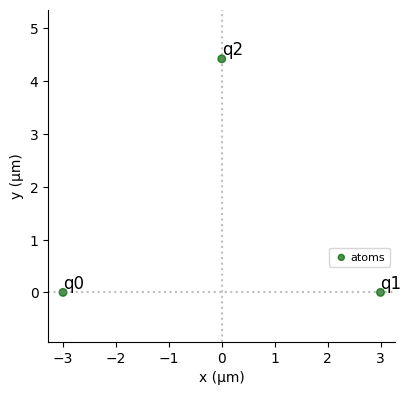

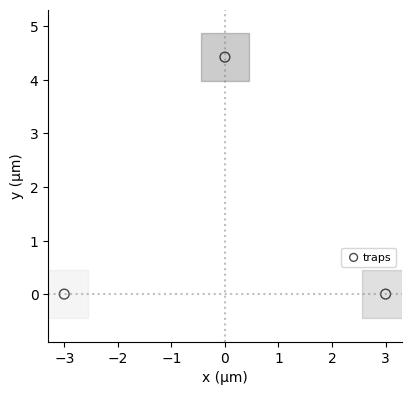

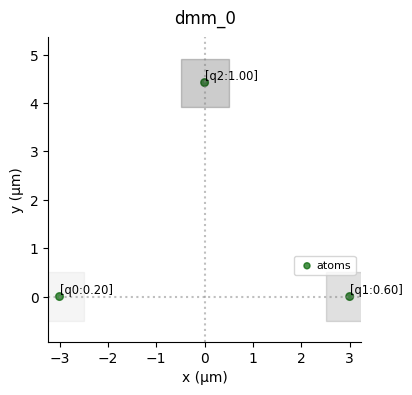

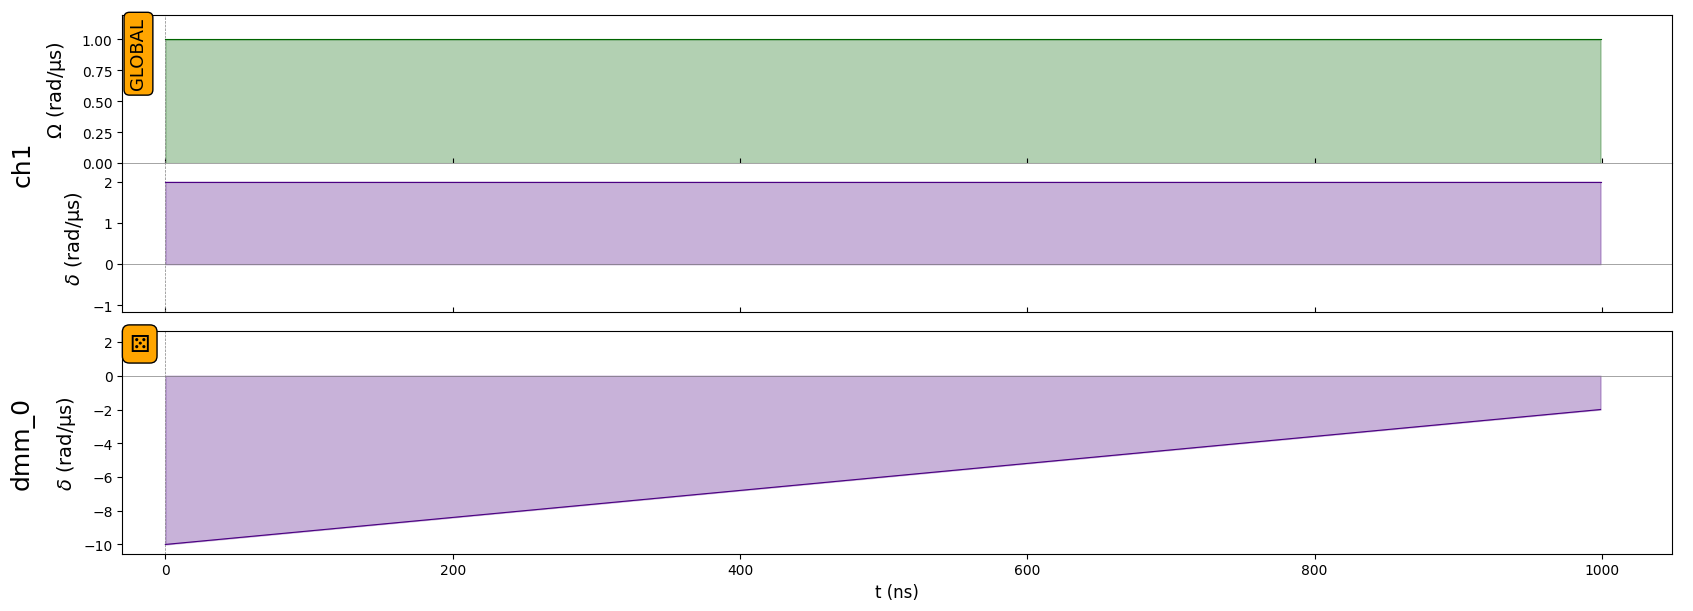

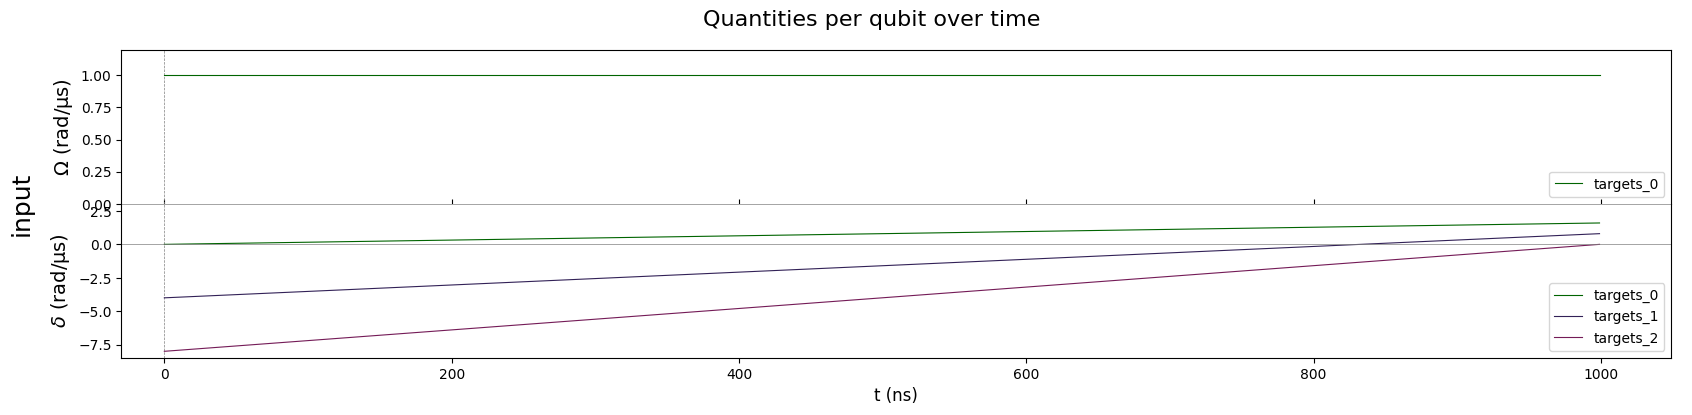

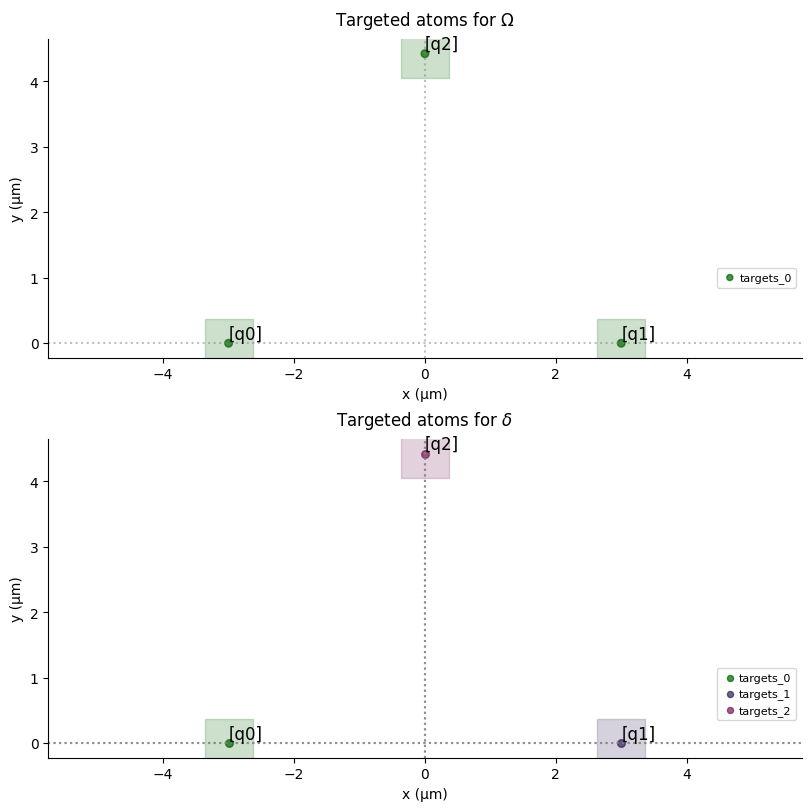

In [99]:
import numpy as np
import pulser
from pulser import Register, Sequence, Pulse
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import RampWaveform
from pulser.register.weight_maps import DetuningMap
import math

# Generate 3-qubit triangle register
def get_registers(distance1, distance2): 
    y = math.sqrt(abs((distance1/2)**2 - distance2**2))
    return Register({
        "q0": (-distance1/2, 0),
        "q1": (distance1/2, 0),
        "q2": (0, y),
    })

R_ij = 6  # distance in micrometers
dist_1 = R_ij
dist_2 = (0.5 * (dist_1 ** 6)) ** (1 / 6)
reg = get_registers(dist_1, dist_2)
reg.draw()

# Define the sequence
seq = Sequence(reg, DigitalAnalogDevice)

# Define per-qubit weights
weights = {
    "q0": 0.2,  # scaled detuning ramp
    "q1": 0.6,
    "q2": 1.0,
}
# 1) Declare the global drive channel
seq.declare_channel("ch1", "rydberg_global")

# 2) Define your Rabi waveform Ω(t).
#    Here we’ll do a simple constant-amplitude pulse lasting 1000 ns at amplitude 1.0 rad/µs:

pulse = Pulse(rabi_freq_amp, detuning=RampWaveform(1000, 2.0, 2.0), phase=0)
seq.add(pulse,"ch1")
# Create detuning map
det_map = reg.define_detuning_map(weights)

det_map.draw()
# Configure DMM channel
seq.config_detuning_map(det_map, "dmm_0")

# Define waveform with negative detuning (required)
ramp = RampWaveform(1000, -10.0, -2.0)  # Must be negative

# Add DMM detuning
seq.add_dmm_detuning(ramp, "dmm_0")


# Draw the sequence to verify per-qubit detunings
seq.draw(draw_detuning_maps=True, draw_qubit_det=True, draw_qubit_amp=True)


In [92]:
from dataclasses import replace
from pulser.devices import MockDevice
from pulser.channels.dmm import DMM

# 1. Patch a MockDevice that includes your DMM config (to simulate DigitalAnalogDevice-style DMMs)
patched_device = replace(
    MockDevice,
    dmm_objects=(DMM(
        clock_period=4,
        min_duration=16,
        mod_bandwidth=8,
        bottom_detuning=-2 * np.pi * 20,            # e.g. −20 MHz
        total_bottom_detuning=-2 * np.pi * 2000     # e.g. −2 GHz
    ),),
    reusable_channels=True
)

# 2. Create the same sequence as before, using the patched device
seq = Sequence(reg, patched_device)
seq.config_detuning_map(det_map, "dmm_0")
seq.declare_channel("ryd_glob", "rydberg_global")
seq.add(Pulse(ConstantWaveform(1000, 1.0), ConstantWaveform(1000, 0.0), 0), "ryd_glob", protocol="no-delay")
seq.add_dmm_detuning(RampWaveform(1000, -10.0, -2.0), "dmm_0")

# 3. Export for Pulser Studio
s_readable = seq.to_abstract_repr(
    json_dumps_options={"indent": 1},
    seq_name="Sequence_with_defaults",
)
with open("dmm3.json", "w") as f:
    f.write(s_readable)
